# 01. 환경 설정

In [2]:
# 라이브러리 가져오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import scipy
import sklearn
import os
import chardet

# matplotlib 하위 모듈
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 마이너스 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 옵션 설정
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# 02. 데이터 불러오기

In [2]:
# 데이터 불러오기
path = './data/'

Data = pd.read_csv(path + 'encoded_data_date_6.csv', encoding='utf-8')  # A_01 부터 체크
A_01 = Data.copy()

Quality = pd.read_excel(path + 'quality.xlsx') # B_01 부터 체크
B_01 = Quality.copy()

## 02-01. 설비 데이터 전처리

In [3]:
# 결측치 및 데이터 타입 체크
A_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2939722 entries, 0 to 2939721
Data columns (total 25 columns):
 #   Column     Dtype  
---  ------     -----  
 0   AN         int64  
 1   DZ1_OP     float64
 2   DZ2_OP     float64
 3   DZ1_TEMP   float64
 4   DZ2_TEMP   float64
 5   CLEAN      float64
 6   HDZ1_OP    float64
 7   HDZ2_OP    float64
 8   HDZ3_OP    float64
 9   HDZ4_OP    float64
 10  HDZ_CP     float64
 11  HDZ_CPM    float64
 12  HDZ1_TEMP  float64
 13  HDZ2_TEMP  float64
 14  HDZ3_TEMP  float64
 15  HDZ4_TEMP  float64
 16  SCZ1_TEMP  float64
 17  SCZ2_TEMP  float64
 18  STZ1_TEMP  float64
 19  Year       int64  
 20  Month      int64  
 21  Day        int64  
 22  Hour       int64  
 23  Minute     int64  
 24  Second     int64  
dtypes: float64(18), int64(7)
memory usage: 560.7 MB


In [4]:
# 데이터의 구조를 보니 차후 배정번호 별, 분 단위 별로 묶으면 될 것 같음
A_01.head(1)

,AN,DZ1_OP,DZ2_OP,DZ1_TEMP,DZ2_TEMP,CLEAN,HDZ1_OP,HDZ2_OP,HDZ3_OP,HDZ4_OP,HDZ_CP,HDZ_CPM,HDZ1_TEMP,HDZ2_TEMP,HDZ3_TEMP,HDZ4_TEMP,SCZ1_TEMP,SCZ2_TEMP,STZ1_TEMP,Year,Month,Day,Hour,Minute,Second
0,102410,73.5091,25.0478,99.5431,99.6467,69.2832,77.2519,59.7862,51.2801,70.3897,0.4495,0.0000,859.0911,859.9875,859.9252,859.9679,285.5743,281.7379,328.8738,2022,1,3,11,22,7


In [5]:
# 데이터 원본 카피
A_02 = A_01.copy()

# 데이터 컬럼에 이상치 값 0으로 배정
A_02['DZ2_OP_Outlier'] = 0

# IQR 계산
thirdq, firstq = A_02['DZ2_OP'].quantile(0.75), A_02['DZ2_OP'].quantile(0.25)
interquartilerange = 1.5 * (thirdq - firstq)
outlierhigh, outlierlow = interquartilerange + thirdq, firstq - interquartilerange

# 이상치 탐지
A_02['DZ2_OP_Outlier'] = ((A_02['DZ2_OP'] > outlierhigh) | (A_02['DZ2_OP'] < outlierlow)).astype(int)

# 결과 출력
print(A_02.head())

       AN  DZ1_OP  DZ2_OP  DZ1_TEMP  DZ2_TEMP   CLEAN  HDZ1_OP  HDZ2_OP  \
0  102410 73.5091 25.0478   99.5431   99.6467 69.2832  77.2519  59.7862   
1  102410 74.5538 23.8251   99.5583   99.6800 69.1850  79.3529  61.6286   
2  102410 75.6776 32.1592   98.8533   99.1460 68.4386  78.1099  61.5414   
3  102410 75.8656 30.8312   98.7918   99.1767 68.4999  77.5072  60.6663   
4  102410 73.6468 29.5274   98.7918   99.2075 68.4386  76.0262  61.1634   

   HDZ3_OP  HDZ4_OP  HDZ_CP  HDZ_CPM  HDZ1_TEMP  HDZ2_TEMP  HDZ3_TEMP  \
0  51.2801  70.3897  0.4495   0.0000   859.0911   859.9875   859.9252   
1  51.9731  71.3202  0.4495   0.0000   859.0312   859.5825   859.7321   
2  52.0196  72.0384  0.4503   0.0000   860.3380   859.7800   859.9810   
3  52.6942  73.4815  0.4502   0.0000   860.3380   859.8420   859.9500   
4  51.6915  71.6093  0.4502   0.0000   860.3510   859.7910   859.9910   

   HDZ4_TEMP  SCZ1_TEMP  SCZ2_TEMP  STZ1_TEMP  Year  Month  Day  Hour  Minute  \
0   859.9679   285.5743   281

## 02-02. 설비 데이터 그룹화

In [6]:
# 시간별로 그룹화
A_03 = A_02.copy()
A_03.drop(['Second', 'Minute'], axis=1, inplace=True)

A_03 = A_03.groupby(['AN', 'Year', 'Month', 'Day', 'Hour']).agg({
    'AN': 'mean',
    'DZ1_OP': 'mean',
    'DZ2_OP': 'mean',
    'DZ1_TEMP': 'mean',
    'DZ2_TEMP': 'mean',
    'CLEAN': 'mean',
    'HDZ1_OP': 'mean',
    'HDZ2_OP': 'mean',
    'HDZ3_OP': 'mean',
    'HDZ4_OP': 'mean',
    'HDZ_CP': 'mean',
    'HDZ_CPM': 'mean',
    'HDZ1_TEMP': 'mean',
    'HDZ2_TEMP': 'mean',
    'HDZ3_TEMP': 'mean',
    'HDZ4_TEMP': 'mean',
    'SCZ1_TEMP': 'mean',
    'SCZ2_TEMP': 'mean',
    'STZ1_TEMP': 'mean',
    'DZ2_OP_Outlier': 'sum'
})

A_03.describe()

,AN,DZ1_OP,DZ2_OP,DZ1_TEMP,DZ2_TEMP,CLEAN,HDZ1_OP,HDZ2_OP,HDZ3_OP,HDZ4_OP,HDZ_CP,HDZ_CPM,HDZ1_TEMP,HDZ2_TEMP,HDZ3_TEMP,HDZ4_TEMP,SCZ1_TEMP,SCZ2_TEMP,STZ1_TEMP,DZ2_OP_Outlier
count,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000,970.0000
mean,128425.0804,69.7614,20.5052,99.9995,99.9997,67.6957,75.5079,54.8416,53.8764,71.0749,0.4483,0.0000,859.2367,860.0026,860.0021,860.0038,283.9327,279.9594,331.8041,236.4990
std,12607.5080,2.8569,4.5777,0.1610,0.2350,1.6013,10.8472,3.6391,1.9790,1.6985,0.0200,0.0000,1.3197,0.1376,0.1130,0.1917,3.4683,2.2891,0.7838,663.3386
min,102410.0000,55.2068,0.6265,98.3104,98.3549,61.9056,3.4079,39.9069,34.4669,48.0232,0.1069,0.0000,853.1818,858.4693,859.0511,859.0359,270.7227,270.8810,328.3078,0.0000
25%,119448.0000,68.9370,19.1563,99.9769,99.9715,66.5809,71.8718,54.1704,53.0735,70.0989,0.4500,0.0000,858.6565,859.9581,859.9717,859.9757,282.0470,278.6496,331.9014,0.0000
50%,129889.0000,70.1733,21.2555,100.0006,100.0086,67.7241,78.3130,55.7571,54.0250,71.0604,0.4501,0.0000,859.3068,860.0027,860.0016,860.0003,284.1221,279.8657,332.0208,0.0000
75%,138938.0000,71.2602,23.0305,100.0300,100.0576,68.9650,82.7064,56.9620,54.8868,72.1276,0.4503,0.0000,859.8775,860.0453,860.0303,860.0264,285.9243,281.2436,332.1248,106.0000
max,148069.0000,75.8619,33.5492,101.6565,101.1385,71.0017,97.6580,63.0725,58.7628,77.1732,0.4843,0.0000,867.0769,861.3677,862.2057,865.3627,297.7669,289.9198,332.4040,3541.0000


In [7]:
A_03.head()

AN  DZ1_OP  DZ2_OP  DZ1_TEMP  DZ2_TEMP  \
AN     Year Month Day Hour                                               
102410 2022 1     3   11    102410 73.2501 24.8670   99.8905  100.1810   
                      12    102410 72.4101 20.4676   99.9949   99.9767   
                      13    102410 70.5052 18.3643   99.9043  100.0814   
102585 2022 1     3   22    102585 72.8980 21.4173   99.9567  100.4232   
                      23    102585 72.5923 18.1548   99.9917  100.0415   

                             CLEAN  HDZ1_OP  HDZ2_OP  HDZ3_OP  HDZ4_OP  \
AN     Year Month Day Hour                                               
102410 2022 1     3   11   69.6934  62.2119  59.0551  50.5300  70.5911   
                      12   69.6177  83.6938  59.5025  50.4305  70.0996   
                      13   69.4428  77.1296  59.3487  51.4435  70.0986   
102585 2022 1     3   22   70.8956  80.5230  60.4992  51.5050  71.4662   
                      23   69.2022  76.0577  58.9792  51.7318  70.2058   

                            HDZ_CP  HDZ_CPM  HDZ1_TEMP  HDZ2_TEMP  HDZ3_TEMP  \
AN     Year Month Day Hour                                                     
102410 2022 1     3   11    0.4494   0.0000   861.6627   860.0917   860.0969   
                      12    0.4502   0.0000   857.8845   859.9457   859.9932   
                      13    0.4526   0.0000   859.9523   860.0476   859.9236   
102585 2022 1     3   22    0.4499   0.0000   858.6884   859.9695   859.9794   
                      23    0.4499   0.0000   859.7761   860.0545   860.0363   

                            HDZ4_TEMP  SCZ1_TEMP  SCZ2_TEMP  STZ1_TEMP  \
AN     Year Month Day Hour                                               
102410 2022 1     3   11     860.0118   281.6291   280.9140   328.9397   
                      12     859.9968   285.7964   277.9390   329.0254   
                      13     860.0392   276.8509   283.9351   329.1021   
102585 2022 1     3   22     859.9384   288.4501   283.4563   329.0104   
                      23     860.0253   282.4817   278.3610   329.0115   

                            DZ2_OP_Outlier  
AN     Year Month Day Hour                  
102410 2022 1     3   11               500  
                      12                 0  
                      13               208  
102585 2022 1     3   22                 0  
                      23                 0

In [8]:
A_03['DZ2_OP_Outlier'].value_counts()

0       509
1        59
3        21
2        20
4        12
       ... 
317       1
323       1
328       1
330       1
1013      1
Name: DZ2_OP_Outlier, Length: 263, dtype: int64

In [9]:
A_03.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 970 entries, (102410, 2022, 1, 3, 11) to (148069, 2022, 7, 19, 19)
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AN              970 non-null    int64  
 1   DZ1_OP          970 non-null    float64
 2   DZ2_OP          970 non-null    float64
 3   DZ1_TEMP        970 non-null    float64
 4   DZ2_TEMP        970 non-null    float64
 5   CLEAN           970 non-null    float64
 6   HDZ1_OP         970 non-null    float64
 7   HDZ2_OP         970 non-null    float64
 8   HDZ3_OP         970 non-null    float64
 9   HDZ4_OP         970 non-null    float64
 10  HDZ_CP          970 non-null    float64
 11  HDZ_CPM         970 non-null    float64
 12  HDZ1_TEMP       970 non-null    float64
 13  HDZ2_TEMP       970 non-null    float64
 14  HDZ3_TEMP       970 non-null    float64
 15  HDZ4_TEMP       970 non-null    float64
 16  SCZ1_TEMP       970 non-null    flo

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DZ2_OP_Outlier', ylabel='Density'>

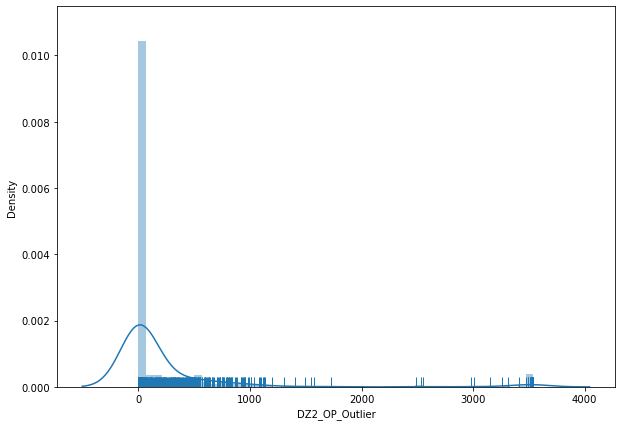

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
sns.distplot(A_03['DZ2_OP_Outlier'], kde=True, rug=True, ax=ax)

In [11]:
A_03['DZ2_OP_Outlier'].value_counts()

0       509
1        59
3        21
2        20
4        12
       ... 
317       1
323       1
328       1
330       1
1013      1
Name: DZ2_OP_Outlier, Length: 263, dtype: int64

In [12]:
Q3 = np.percentile(A_03['DZ2_OP_Outlier'], 75)

In [13]:
A_03['DZ2_OP_Signal'] = np.where(A_03['DZ2_OP_Outlier'] <= Q3, 0, 1)
A_03['DZ2_OP_Signal'].value_counts()

0    728
1    242
Name: DZ2_OP_Signal, dtype: int64

In [14]:
A_03.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 970 entries, (102410, 2022, 1, 3, 11) to (148069, 2022, 7, 19, 19)
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AN              970 non-null    int64  
 1   DZ1_OP          970 non-null    float64
 2   DZ2_OP          970 non-null    float64
 3   DZ1_TEMP        970 non-null    float64
 4   DZ2_TEMP        970 non-null    float64
 5   CLEAN           970 non-null    float64
 6   HDZ1_OP         970 non-null    float64
 7   HDZ2_OP         970 non-null    float64
 8   HDZ3_OP         970 non-null    float64
 9   HDZ4_OP         970 non-null    float64
 10  HDZ_CP          970 non-null    float64
 11  HDZ_CPM         970 non-null    float64
 12  HDZ1_TEMP       970 non-null    float64
 13  HDZ2_TEMP       970 non-null    float64
 14  HDZ3_TEMP       970 non-null    float64
 15  HDZ4_TEMP       970 non-null    float64
 16  SCZ1_TEMP       970 non-null    flo

# 03. 함수화

In [34]:
path = './data/'

data = pd.read_csv(path + 'encoded_data_date_6.csv', encoding='utf-8')  # A_01 부터 체크

In [35]:
def get_pp_df(column):
    df = data.copy()
    
    # 데이터 컬럼에 이상치 값 0으로 배정
    df['Outlier'] = 0

    # IQR 계산
    thirdq, firstq = df[column].quantile(0.75), df[column].quantile(0.25)
    interquartilerange = 1.5 * (thirdq - firstq)
    outlierhigh, outlierlow = interquartilerange + thirdq, firstq - interquartilerange

    # 이상치 탐지
    df['Outlier'] = ((df[column] > outlierhigh) | (df[column] < outlierlow)).astype(int)
    
    # 시간별로 그룹화
    df.drop(['Minute', 'Second'], axis=1, inplace=True)

    df = df.groupby(['AN', 'Year', 'Month', 'Day', 'Hour']).agg({
        'DZ1_OP': 'mean',
        'DZ2_OP': 'mean',
        'DZ1_TEMP': 'mean',
        'DZ2_TEMP': 'mean',
        'CLEAN': 'mean',
        'HDZ1_OP': 'mean',
        'HDZ2_OP': 'mean',
        'HDZ3_OP': 'mean',
        'HDZ4_OP': 'mean',
        'HDZ_CP': 'mean',
        'HDZ_CPM': 'mean',
        'HDZ1_TEMP': 'mean',
        'HDZ2_TEMP': 'mean',
        'HDZ3_TEMP': 'mean',
        'HDZ4_TEMP': 'mean',
        'SCZ1_TEMP': 'mean',
        'SCZ2_TEMP': 'mean',
        'STZ1_TEMP': 'mean',
        'Outlier': 'sum'
    }).reset_index()
    
    # 이상치기준으로 Q3정의
    Q3 = np.percentile(df['Outlier'], 75)
    
    # 'Outlier'컬럼 값이 Q3보다 작으면 0, 크거나 같으면 1 할당
    df[f'{column}_Signal'] = np.where(df['Outlier'] < Q3, 0, 1)
    
    return df

In [44]:
df = get_pp_df('DZ2_OP')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AN             970 non-null    int64  
 1   Year           970 non-null    int64  
 2   Month          970 non-null    int64  
 3   Day            970 non-null    int64  
 4   Hour           970 non-null    int64  
 5   DZ1_OP         970 non-null    float64
 6   DZ2_OP         970 non-null    float64
 7   DZ1_TEMP       970 non-null    float64
 8   DZ2_TEMP       970 non-null    float64
 9   CLEAN          970 non-null    float64
 10  HDZ1_OP        970 non-null    float64
 11  HDZ2_OP        970 non-null    float64
 12  HDZ3_OP        970 non-null    float64
 13  HDZ4_OP        970 non-null    float64
 14  HDZ_CP         970 non-null    float64
 15  HDZ_CPM        970 non-null    float64
 16  HDZ1_TEMP      970 non-null    float64
 17  HDZ2_TEMP      970 non-null    float64
 18  HDZ3_TEMP 

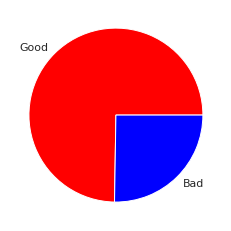

In [32]:
data1 = df['DZ2_OP_Signal'].value_counts()
labels = ['Good', 'Bad']
colors = ['red', 'blue']

plt.pie(data1, labels=labels, colors=colors)
plt.show()

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df

,AN,Year,Month,Day,Hour,DZ1_OP,DZ2_OP,DZ1_TEMP,DZ2_TEMP,CLEAN,HDZ1_OP,HDZ2_OP,HDZ3_OP,HDZ4_OP,HDZ_CP,HDZ_CPM,HDZ1_TEMP,HDZ2_TEMP,HDZ3_TEMP,HDZ4_TEMP,SCZ1_TEMP,SCZ2_TEMP,STZ1_TEMP,Outlier,DZ2_OP_Signal
0,0.0000,0.0000,0.0000,0.0667,0.4783,0.8736,0.7363,0.4722,0.6560,0.8562,0.6239,0.8266,0.6611,0.7742,0.9077,0.3192,0.6103,0.5598,0.3315,0.1543,0.4033,0.5270,0.1543,0.1412,1.0000
1,0.0000,0.0000,0.0000,0.0667,0.5217,0.8329,0.6027,0.5034,0.5826,0.8478,0.8518,0.8459,0.6571,0.7573,0.9098,0.2870,0.3384,0.5094,0.2986,0.1519,0.5574,0.3707,0.1752,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0667,0.5652,0.7407,0.5388,0.4763,0.6203,0.8286,0.7822,0.8393,0.6987,0.7573,0.9159,0.2653,0.4873,0.5445,0.2766,0.1586,0.2266,0.6857,0.1939,0.0587,1.0000
3,0.0038,0.0000,0.0000,0.0667,0.9565,0.8565,0.6315,0.4920,0.7430,0.9883,0.8182,0.8889,0.7013,0.8042,0.9089,0.2804,0.3963,0.5176,0.2942,0.1426,0.6555,0.6605,0.1715,0.0000,0.0000
4,0.0038,0.0000,0.0000,0.0667,1.0000,0.8417,0.5324,0.5025,0.6059,0.8022,0.7708,0.8233,0.7106,0.7610,0.9090,0.3002,0.4746,0.5469,0.3123,0.1564,0.4348,0.3929,0.1718,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,1.0000,0.0000,1.0000,0.6000,0.6522,0.7069,0.0802,0.5163,0.6870,0.8976,0.8127,0.8311,0.8218,0.8814,0.9091,0.3068,0.4761,0.5300,0.3190,0.1585,0.4249,0.4541,0.9456,0.9958,1.0000
966,1.0000,0.0000,1.0000,0.6000,0.6957,0.7273,0.0151,0.4942,0.6758,0.8453,0.8162,0.8282,0.8161,0.8854,0.9091,0.2978,0.4896,0.5325,0.3100,0.1495,0.5590,0.4710,0.9542,0.9864,1.0000
967,1.0000,0.0000,1.0000,0.6000,0.7391,0.6987,0.0137,0.5167,0.6691,0.9630,0.5882,0.7100,0.8402,0.8798,0.9094,0.2737,0.5866,0.5693,0.2850,0.1582,0.5945,0.6308,0.9731,0.9966,1.0000
968,1.0000,0.0000,1.0000,0.6000,0.7826,0.5939,0.0128,0.5703,0.7429,0.7372,0.7772,0.7875,0.8130,0.8695,0.9098,0.2906,0.3724,0.4841,0.3023,0.1526,0.4661,0.4995,0.9295,0.9966,1.0000
